# Speaker Diarization Using CNN

In [ ]:
%cd /content/drive/MyDrive/EE698 speaker diarization project/100 speaker dataset/

[Errno 2] No such file or directory: '/content/drive/MyDrive/EE698 speaker diarization project/100 speaker dataset/'
/content


In [ ]:
ls

96s_adam_model_thl.h5        mel_save_test_IS1000c.npy
96s_sgd_model_thl.h5         mel_save_test_TS3010c.npy
mel_labels_test_IB4011.npy   mel_save_train.npy
mel_labels_test_IS1000c.npy  timestamps_save_IB4011.npy
mel_labels_test_TS3010c.npy  timestamps_save_IS1000c.npy
mel_labels_train.npy         timestamps_save_TS3010c.npy
mel_save_test_IB4011.npy


## Loading libraries and importing packages


In [ ]:
!pip3 install spectralcluster
!pip install tensorflow_addons 
!pip install pyannote.core
!pip install pyannote.metrics

     |████████████████████████████████| 706kB 18.6MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 133kB 22.6MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 


In [ ]:
%pylab inline
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from pyannote.core import Annotation, Segment
from keras.utils.vis_utils import plot_model
from spectralcluster import SpectralClusterer
from sklearn.manifold import TSNE

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [ ]:
X = np.load('./mel_save_train.npy') # mfcc features of dimension 20
y = np.load('./mel_labels_train.npy') # true speaker labels of those feature vector

In [ ]:
X=X.reshape(-1,44,20,1 )        # Reshaping for transforming in appropriate format for CNN
print(X.shape)
print(y.shape)

(16040, 44, 20, 1)
(16040,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

In [ ]:
def _map_sound(img, label):
    return (img, label)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset= train_dataset.batch(32)
train_dataset = train_dataset.map(_map_sound)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset= test_dataset.batch(32)
test_dataset = test_dataset.map(_map_sound)

## Model Architecture and Training

In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape = (44,20,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.04),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.04),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.04),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.04),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 20, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 5, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 5, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 5, 128)        7

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(         # Use Stochastic gradient descent for optimizing the model
    learning_rate=0.001, momentum=0.001),
    loss=tfa.losses.TripletHardLoss())         # Use Triplet Hard Loss for making same speaker embeddings similar

In [ ]:
history = model.fit(train_dataset,epochs=150, validation_data=test_dataset)   # Training

Epoch 1/150
452/452 [==============================] - 36s 6ms/step - loss: 0.5829 - val_loss: 0.5063
Epoch 2/150
452/452 [==============================] - 2s 4ms/step - loss: 0.3742 - val_loss: 0.4907
Epoch 3/150
452/452 [==============================] - 2s 4ms/step - loss: 0.3722 - val_loss: 0.4773
Epoch 4/150
452/452 [==============================] - 2s 4ms/step - loss: 0.3719 - val_loss: 0.4719
Epoch 5/150
452/452 [==============================] - 2s 4ms/step - loss: 0.3714 - val_loss: 0.4872
Epoch 6/150
452/452 [==============================] - 2s 4ms/step - loss: 0.3700 - val_loss: 0.4685
Epoch 7/150
452/452 [==============================] - 2s 4ms/step - loss: 0.3692 - val_loss: 0.4750
Epoch 8/150
452/452 [==============================] - 2s 4ms/step - loss: 0.3698 - val_loss: 0.4791
Epoch 9/150
452/452 [==============================] - 2s 4ms/step - loss: 0.3693 - val_loss: 0.4786
Epoch 10/150
452/452 [==============================] - 2s 4ms/step - loss: 0.3673 - val_l

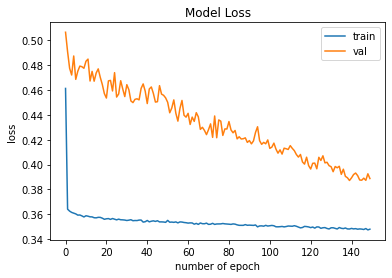

In [ ]:
plt.plot(history.history['loss'])        # Plotting the train and validation loss accross epochs to analyze performance change
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('number of epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model.save('96s_sgd_model_thl_2.h5')        # Saving trained model

## Testing the model on AMI datacorpus
We take 3 audio files: IB4011, IS1000c, TS3010c, calculate DER, and average the errors.

In [ ]:
def load_test_file(x_loc, y_loc, time_stamp_loc):
    X_test_us = np.load(x_loc) # mfcc features of dimension 20
    y_test_us = np.load(y_loc) # true speaker labels of those feature vector
    time_stamp_us = np.load(time_stamp_loc) # true speaker labels of those feature vector
    return (X_test_us, y_test_us, time_stamp_us)
def _map_sound(img, label):
    return (img, label)

In [ ]:
def plot_scatter_embedding(embedding_2d, y_label, graph_title):        # For plotting 2D graph of embeddings
    a=[]
    b=[]
    colors = ['black','red','green','blue','pink','brown'
            ]
    color_list = []
    for i in range(embedding_2d.shape[0]):
      a.append(embedding_2d[i][0])
      color_list.append(colors[y_label[i]])
    for i in range(embedding_2d.shape[0]):
      b.append(embedding_2d[i][1])
    plt.scatter(a,b,color = color_list)
    plt.title(graph_title)
    plt.show()


def make_spectral_clusters(test_d_vector_embedding):               # Returns predictd values from spectral clustering of the embeddings

    clusterer = SpectralClusterer(
        min_clusters=4,
        max_clusters=6,
        p_percentile=0.90,
        gaussian_blur_sigma=0.0)
    y_test_pred_spectral_us = clusterer.predict(test_d_vector_embedding_us)
    return y_test_pred_spectral_us

In [ ]:
def resegment(y_test_pred_spectral_us):                   # Resegmentation of the predicted values for better accuracy
    i=2
    y1=[]
    y1.append(y_test_pred_spectral_us[0])
    y1.append(y_test_pred_spectral_us[1])
    for label_ in y_test_pred_spectral_us:
      if(i>=len(y_test_pred_spectral_us)-3):
        break
      if y_test_pred_spectral_us[i-2]==y_test_pred_spectral_us[i-1] and y_test_pred_spectral_us[i-1]==y_test_pred_spectral_us[i+1] and y_test_pred_spectral_us[i+1]==y_test_pred_spectral_us[i+2]:
        y1.append(y_test_pred_spectral_us[i-1])           # Changing the sandwitched value for reasonable prediction
      else:
        y1.append(y_test_pred_spectral_us[i])
      i=i+1

    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-3])
    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-2])
    y1.append(y_test_pred_spectral_us[len(y_test_pred_spectral_us)-1])
    return y1

In [ ]:
def der_calculation(reference, hypothesis):                   # Calculating Diarization Error Rate
  from pyannote.metrics.diarization import DiarizationErrorRate
  diarizationErrorRate = DiarizationErrorRate()
  print("DER = {0:.3f}".format(diarizationErrorRate(reference, hypothesis, uem=Segment(0, 600))))
  print(diarizationErrorRate.optimal_mapping(reference, hypothesis))
  print(diarizationErrorRate(reference, hypothesis, detailed=True, uem=Segment(0, 600)))

def pyannote_graph(speaker_dictionary, time_stamp, y_label):
    reference = Annotation()
    speaker_dict_true= speaker_dictionary
    for i in range(time_stamp.shape[0]):
      reference[Segment(time_stamp[i][0], time_stamp[i][1])]= speaker_dict_true[ y_label[i]]
    return reference


processing files of:  IB4011
Shape of Test_d-vector_embedding:  (1876, 256)
Shape of Test unseen 2d embedding shape:  (1876, 2)


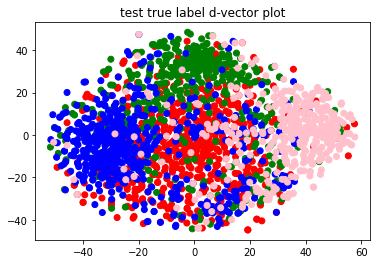

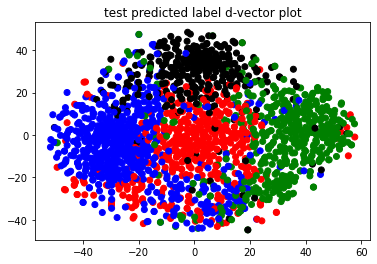

DER = 0.258
{'a': 'B', 'b': 'A', 'c': 'D', 'd': 'C'}
{'false alarm': 0.0, 'correct': 359.68700000000007, 'total': 484.65, 'missed detection': 0.0, 'confusion': 124.96299999999994, 'diarization error rate': 0.2578417414629113}
DER = 0.205
{'a': 'B', 'b': 'A', 'c': 'D', 'd': 'C'}
{'false alarm': 0.0, 'correct': 385.11100000000005, 'total': 484.65, 'missed detection': 0.0, 'confusion': 99.53899999999996, 'diarization error rate': 0.2053832662746311}
processing files of:  IS1000c
Shape of Test_d-vector_embedding:  (1629, 256)
Shape of Test unseen 2d embedding shape:  (1629, 2)


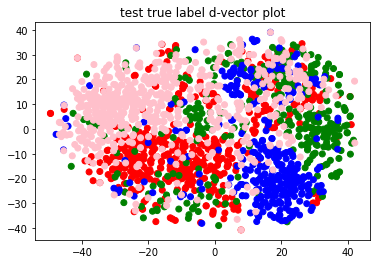

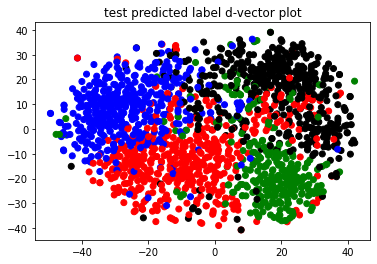

DER = 0.260
{'a': 'B', 'b': 'A', 'c': 'C', 'd': 'D'}
{'false alarm': 0.0, 'correct': 264.7599999999997, 'total': 357.94299999999987, 'missed detection': 0.0, 'confusion': 93.18300000000016, 'diarization error rate': 0.260329158553178}
DER = 0.182
{'a': 'B', 'b': 'A', 'c': 'C', 'd': 'D'}
{'false alarm': 0.0, 'correct': 292.7599999999997, 'total': 357.94299999999987, 'missed detection': 0.0, 'confusion': 65.18300000000016, 'diarization error rate': 0.18210441327250482}
processing files of:  TS3010c
Shape of Test_d-vector_embedding:  (1136, 256)
Shape of Test unseen 2d embedding shape:  (1136, 2)


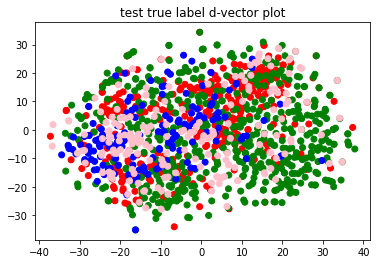

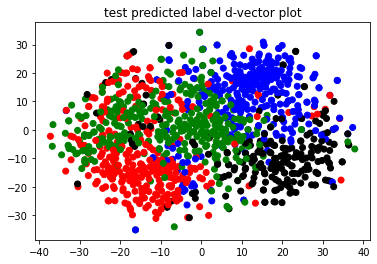

DER = 0.542
{'a': 'B', 'b': 'D', 'c': 'C', 'd': 'A'}
{'false alarm': 0.0, 'correct': 190.02400000000003, 'total': 414.62500000000006, 'missed detection': 0.0, 'confusion': 224.601, 'diarization error rate': 0.5416967138981006}
DER = 0.518
{'a': 'B', 'b': 'D', 'c': 'C', 'd': 'A'}
{'false alarm': 0.0, 'correct': 200.02400000000003, 'total': 414.62500000000006, 'missed detection': 0.0, 'confusion': 214.601, 'diarization error rate': 0.517578534820621}


In [ ]:
test_list=['IB4011', 'IS1000c', 'TS3010c']
for test_data_us in test_list:
  print("processing files of: ", test_data_us)
  x_loc='./mel_save_test_'+test_data_us+'.npy'
  y_loc='./mel_labels_test_'+test_data_us+'.npy'
  time_stamp_loc='./timestamps_save_'+test_data_us+'.npy'
  X_test_us, y_test_us, time_stamp_us=load_test_file(x_loc, y_loc, time_stamp_loc)
  X_test_us=X_test_us.reshape(-1,44,20,1 )
  test_dataset_us = tf.data.Dataset.from_tensor_slices((X_test_us, y_test_us))
  test_dataset_us= test_dataset_us.batch(32)
  test_dataset_us = test_dataset_us.map(_map_sound)
  test_d_vector_embedding_us = model.predict(test_dataset_us)               # Getting Embeddings using CNN model
  print("Shape of Test_d-vector_embedding: ", test_d_vector_embedding_us.shape)
  test_2d_embedding_us = TSNE(n_components=2).fit_transform(test_d_vector_embedding_us)  # Applying PCA to convert into 2D for plotting
  print("Shape of Test unseen 2d embedding shape: ", test_2d_embedding_us.shape)
  plot_scatter_embedding(test_2d_embedding_us, y_test_us, "test true label d-vector plot")
  y_test_pred_spectral_us=make_spectral_clusters(test_d_vector_embedding_us)  # Using spectral clustering for predictions
  y1=resegment(y_test_pred_spectral_us)
  plot_scatter_embedding(test_2d_embedding_us, y_test_pred_spectral_us, "test predicted label d-vector plot")
  speaker_dict_true={1:'A', 2:'B', 3:'C', 4:'D'}
  speaker_dict_hypo={0:'a', 1:'b', 2:'c', 3:'d'}
  reference= pyannote_graph(speaker_dict_true, time_stamp_us,  y_test_us)   # Getting the actual timeline of speakers
  hypothesis= pyannote_graph(speaker_dict_hypo, time_stamp_us,  y_test_pred_spectral_us)   # Getting the predicted timeline of speakers
  hypothesis_1= pyannote_graph(speaker_dict_hypo, time_stamp_us,  y1)
  der_calculation(reference, hypothesis)                                    # Calculating Diarization Error Rate
  der_calculation(reference, hypothesis_1)


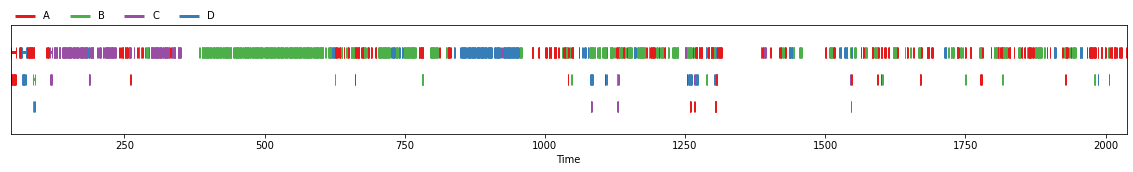

In [ ]:
reference    # Actual timeline of speakers in file 'TS3010c' of AMI corpus

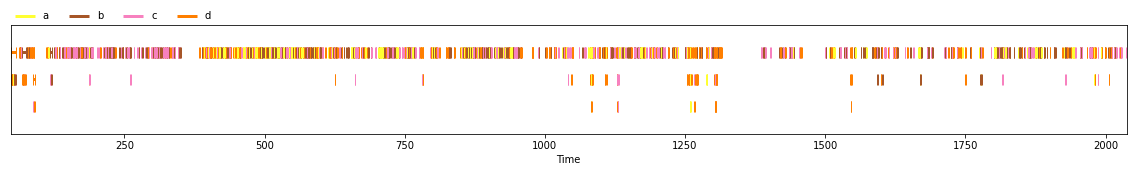

In [ ]:
hypothesis   # Predicted timeline of speakers in file 'TS3010c' of AMI corpus